# Simple Q-learning agent

The notebook provides a quick training of [Q-learning](https://link.springer.com/article/10.1007/bf00992698) algorithm on the `ElevatorEnv` environment.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/gym4ReaL


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from tqdm import tqdm
import pickle
from collections import OrderedDict
from gymnasium.utils.env_checker import check_env
import gymnasium as gym

from gym4real.envs.elevator.utils import parameter_generator

In [40]:
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context("paper")
plot_colors = sns.color_palette('colorblind')
sns.set(font_scale=1.2)

alg_color = OrderedDict({
    'random': plot_colors[1],
    'longest_first': plot_colors[2],
    'q-learning': plot_colors[0],
})

## Q-Learning Agent
We are adopting a custom version of Q-Learning to solve the tabular MDP.

In [41]:
n_episodes = 100

In [42]:
params = parameter_generator(lambda_min=0.01, lambda_max=0.1, seed=42)
params

{'min_floor': 0,
 'max_floor': 4,
 'max_capacity': 4,
 'movement_speed': 3.0,
 'floor_height': 6,
 'max_arrivals': 2,
 'max_queue_length': 3,
 'duration': 3600,
 'timestep': 1,
 'goal_floor': 0,
 'init_elevator_pos': None,
 'random_init_state': False,
 'arrival_distributions': {'lambda_min': 0.01, 'lambda_max': 0.1, 'seed': 42}}

In [43]:
env = gym.make("gym4real/elevator-v0",  **{'settings':params})

In [44]:
alpha = 0.1
gamma = 1
epsilon = 1.0
epsilon_decay = 0.99
epsilon_min = 0.05

def default_q_values():
        return np.zeros(3)
    
def obs_to_key(obs):
        # Manually flatten the dict to a tuple of ints
        return (
            obs['current_position'],
            obs['n_passengers'],
            #obs['speed'],
            *obs['floor_queues'],
            *obs['arrivals']
        )

In [45]:
from collections import defaultdict

actions_size = env.action_space.n
Q = defaultdict(default_q_values)
    
for episode in tqdm(range(n_episodes)):
    obs, _ = env.reset()
    obs_key = obs_to_key(obs)
    
    cumulated_reward = 0        
    
    rng = np.random.default_rng(seed=42)
    done = False
    while not done:
        if rng.uniform() < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(Q[obs_key])     # Exploit learned values
        
        new_obs, reward, terminated, truncated, _ = env.step(action) 
        new_obs_key = obs_to_key(new_obs)
                    
        cumulated_reward += reward
        done = terminated or truncated
        
        # Q-update
        best_next_action = np.argmax(Q[new_obs_key])
        td_target = reward + gamma * Q[new_obs_key][best_next_action]
        Q[obs_key][action] += alpha * (td_target - Q[obs_key][action])

        obs, obs_key = new_obs, new_obs_key
        
    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

#with open(f"examples/elevator/trained_models/Qtable_quick.pkl", "wb") as output_file:
#    pickle.dump(Q, output_file)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.86it/s]


## Comparison with Random policy

Here we will compare the Q-Learning table saved with a simple random policy and another rule-based policy. The policies will be compared on several arrival profiles with another seed.

In [46]:
eval_params = parameter_generator(seed=1234)

eval_episodes = 30
rewards = {}

### Random Policy
The action is chosen randomly at each decision step by randomly sampling within the action space.

In [47]:
env = gym.make("gym4real/elevator-v0", **{'settings':eval_params})

alg = 'random'
rewards[alg] = {}

for episode in tqdm(range(eval_episodes)):
    obs, info = env.reset()
    done = False
    cumulated_reward = 0
    rewards[alg][episode] = []
    
    while not done:
        action = env.action_space.sample()  # Randomly select an action
        obs, reward, terminated, truncated, info = env.step(action)  
        done = terminated or truncated
        cumulated_reward += reward
        rewards[alg][episode].append(cumulated_reward)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.94it/s]


### Longest Queue First Policy
The `longest_first` policy gives priority to the floor with more waiting people.

In [48]:
env = gym.make("gym4real/elevator-v0", **{'settings':eval_params})

alg = 'longest_first'
rewards[alg] = {}

for episode in tqdm(range(eval_episodes)):
    obs, info = env.reset()
    done = False
    cumulated_reward = 0
    rewards[alg][episode] = []
        
    while not done:
        if obs['n_passengers'] > 0:
            if obs['current_position'] * info['movement_speed'] / info['floor_height'] == info['goal_floor']:
                action = 1  # stay still
            else:
                action = 0  # move down
        else:
            # Check if any passengers are waiting on the current floor
            len_max_queue, idx_max_queue = max((queue, idx+1) for idx, queue in enumerate(obs['floor_queues']))
            
            if len_max_queue == 0:
                action = 1  # stay still
            else:
                if obs['current_position'] * info['movement_speed'] == (idx_max_queue) * info['floor_height']:
                    action = 1  # stay still
                elif obs['current_position'] * info['movement_speed'] < (idx_max_queue) * info['floor_height']:
                    action = 2  # move up            
                elif obs['current_position'] * info['movement_speed'] > (idx_max_queue) * info['floor_height']:
                    action = 0
                else:
                    action = 1
                    
        obs, reward, terminated, truncated, info = env.step(action)
        cumulated_reward += reward
        done = terminated or truncated
        rewards[alg][episode].append(cumulated_reward)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.42it/s]


### Q-Learning
We test with the Q-Learning model trained so far, importing the saved `Qtable_quick.pkl` serialized object.

In [49]:
env = gym.make("gym4real/elevator-v0", **{'settings':eval_params})

alg = 'q-learning'
rewards[alg] = {}
with open('examples/elevator/trained_models/trained_qlearning_Qtable.pkl', 'rb') as f:
    Q = pickle.load(f)

for episode in tqdm(range(eval_episodes)):
    obs, _ = env.reset()
    obs_key = obs_to_key(obs)
    
    done = False
    cumulated_reward = 0
    rewards[alg][episode] = []
        
    while not done:
        action = np.argmax(Q[obs_key])  # Exploit learned values
        new_obs, reward, terminated, truncated, _ = env.step(action)
        new_obs_key = obs_to_key(new_obs)
        
        cumulated_reward += reward
        done = terminated or truncated
        obs_key = new_obs_key
        rewards[alg][episode].append(cumulated_reward)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.88it/s]


Let's compare the cumulative rewards averaged among the test profiles between `Q-Learning` undergone a quick training, the `random` policy and the `longest_first` policy.

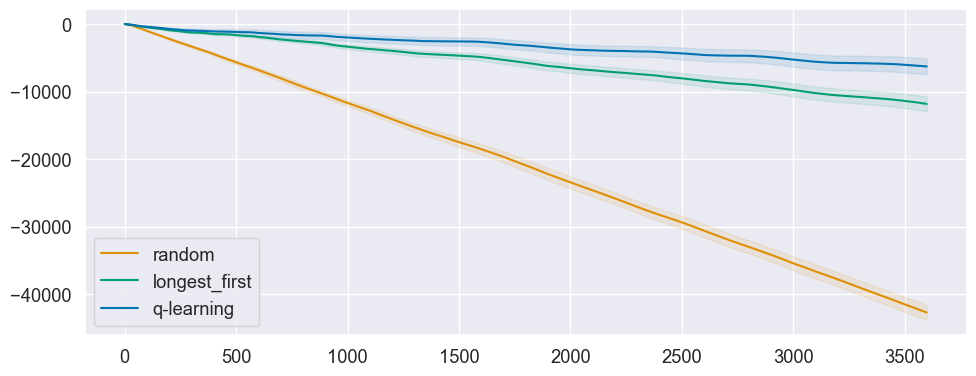

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)

for i, alg in enumerate(rewards.keys()):
    means = np.mean([(rewards[alg][profile]) for profile in rewards[alg].keys()], axis=0)
    stds = np.std([(rewards[alg][profile]) for profile in rewards[alg].keys()], axis=0)
    ci = 1.96 * stds/np.sqrt(len(rewards[alg].keys()))
    
    ax.plot(means, label=alg, color=alg_color[alg])        
    ax.fill_between(range(len(means)), means + ci, means - ci, alpha=0.1, color=alg_color[alg])
    ax.legend()